## How to Use EvalxNLP Framework for Hate Speech Detection – A Beginner-Friendly Guide 🚀

Hate speech detection is a Natural Language Processing (NLP) task that involves identifying and classifying text that expresses hatred, discrimination, or violence against individuals or groups based on attributes such as race, religion, gender, or sexual orientation.

### Hate Speech Detection:
- **Hate Speech**: Text that explicitly promotes hatred or violence.
- **Offensive Language**: Text that is rude or offensive but does not explicitly promote hatred.
- **Neutral**: Text that does not contain hate speech or offensive language.

In [128]:
import sys
sys.path.append('..')
from XAIbenchmark import XAIFramework
import warnings

warnings.filterwarnings("ignore")

In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Single Sentence

Step 1: Load a pre-trained Hate Speech detection Model, and Tokenizer

In [130]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "Hate-speech-CNERG/bert-base-uncased-hatexplain"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Step 2: Optionally initialize the explainers, and evaluators

In [131]:
import torch
from explainers import InputXGradientExplainer, IntegratedGradientsExplainer, DeepLiftExplainer, LimeExplainer, SHAPExplainer, SHAPIQExplainer, GuidedBackpropExplainer
device = "cuda" if torch.cuda.is_available() else "cpu"
ig= IntegratedGradientsExplainer(model,tokenizer,device)
gb= GuidedBackpropExplainer(model,tokenizer,device)
dl= DeepLiftExplainer(model,tokenizer,device)
ixg= InputXGradientExplainer(model,tokenizer,device,multiply_by_inputs=True)
g= InputXGradientExplainer(model,tokenizer,device,multiply_by_inputs=False)
lime= LimeExplainer(model,tokenizer)
shap= SHAPExplainer(model,tokenizer)
shapiq= SHAPIQExplainer(model,tokenizer)

In [132]:
from evaluators import AUCTPEvaluator, SoftComprehensivenessEvaluator, SoftSufficiencyEvaluator, FADEvaluator, SparsenessEvaluator, ComplexityEvaluator, IOUF1Evaluator,TokenF1Evaluator, AUPRCEvaluator

sc= SoftComprehensivenessEvaluator(model,tokenizer,device)
ss= SoftSufficiencyEvaluator(model,tokenizer,device)
fad= FADEvaluator(model,tokenizer,device)
sp= SparsenessEvaluator(model,tokenizer,device)
cx= ComplexityEvaluator(model,tokenizer,device)
auctp= AUCTPEvaluator(model,tokenizer,device)
iou_f1= IOUF1Evaluator(model,tokenizer,device)
token_f1= TokenF1Evaluator(model,tokenizer,device)
auprc= AUPRCEvaluator(model,tokenizer,device)

Step 3: Inialize XAIBenchmark Class

In [133]:
xai_framework = XAIFramework(model, tokenizer,explainers=[dl], evaluators=[auprc],device=device)

> **Note:** If you don’t pass any explainers or evaluators, it defaults to all explainers/evaluators.

Step 4: Detect Hate Speech

In [8]:
sentence= "I hate people from that community"
xai_framework.classify_text(sentence)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


{'hate speech': 0.06156373396515846,
 'normal': 0.6611422896385193,
 'offensive': 0.27729398012161255}

Step 5: Use EvalxNLP to Explain Why

You can use the `XAIBenchmark` class to explain for all the explainers defined during the initiation of the `XAIBenchmark` class

In [ ]:
exps= xai_framework.explain(input_data=sentence,target_label="offensive")

Or you can use an individual explainer's `compute_feature_importance` method to get importance scores.

In [28]:
ig_exps= ig.compute_feature_importance(sentence, target="offensive")
gb_exps= gb.compute_feature_importance(sentence, target="offensive")
dl_exps= dl.compute_feature_importance(sentence, target="offensive")
ixg_exps= ixg.compute_feature_importance(sentence, target="offensive")
lime_exps= lime.compute_feature_importance(sentence, target="offensive")
shap_exps= shap.compute_feature_importance(sentence, target="offensive")
shapiq_exps= shapiq.compute_feature_importance(sentence, target="offensive")
g_exps= g.compute_feature_importance(sentence, target="offensive")

Running Inference: 100%|██████████| 8/8 [00:24<00:00,  3.05s/it]


Step 5: Visualize the Explanation

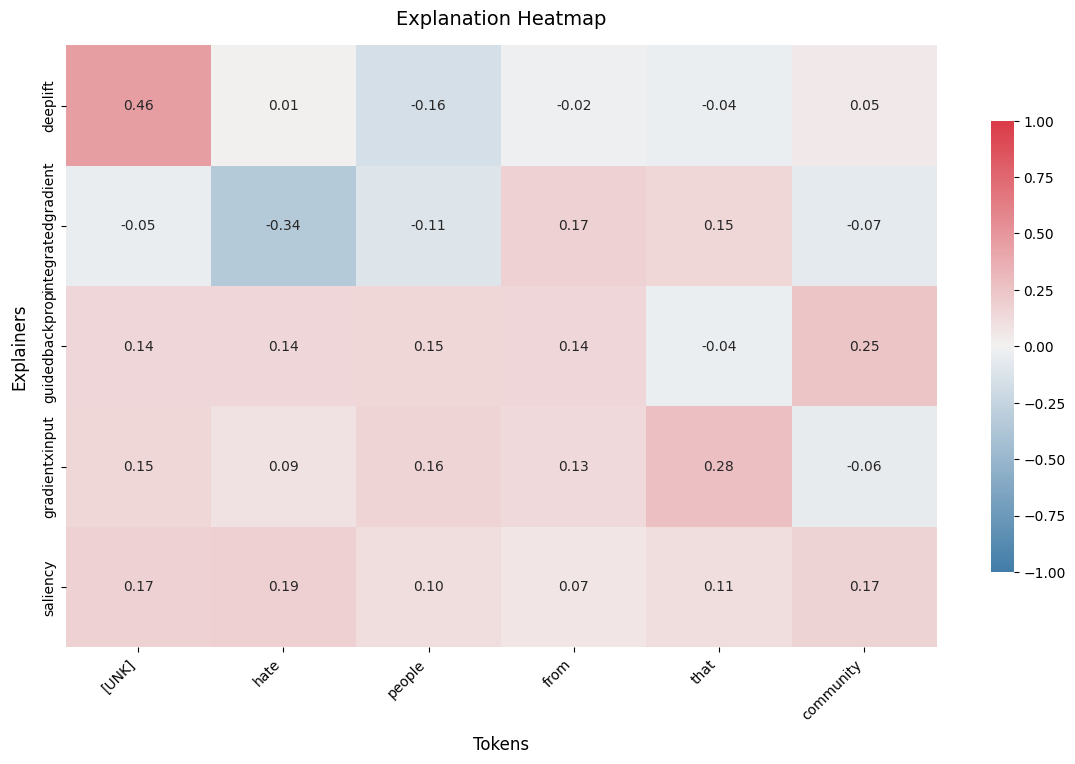

In [54]:
xai_framework.visualize(exps)

📌 How to Interpret EvalxNLP's Results?

This heatmap shows how different explanation methods (feature attribution techniques) assign importance scores to different words (tokens) in a sentence.

Each row represents a different explanation method, and each column represents a token (word or punctuation) from the input sentence.

🔴 Red (Positive Score) → Word contributes positively to the prediction.

🔵 Blue (Negative Score) → Word contributes negatively to the prediction.

⚪ White/Neutral (Close to 0) → Word has little to no effect on the prediction.



Step 5: Evaluate the explanations

You can evaluate explanations from different explainers initialized during the creation of the `XAIBenchmark` class using the `evaluate_single_sentence` function.

- If you provide a **human rationale**, **plausibility metrics** will be calculated.  
- If no rationale is provided, plausibility metrics **will not** be included.  

In [ ]:
xai_framework.evaluate_single_sentence(sentence, target_label="offensive")

explainer deeplift
explainer integratedgradient
explainer guidedbackprop


Evaluator,Complexity,Sparseness,Token F1 score
Explainer,,,
deeplift,0.169709,0.248963,0.5
guidedbackprop,0.136688,0.466892,0.5
integratedgradient,0.150333,0.394562,0.5


Alternatively, you can use each evaluator’s `compute` function to assess individual metrics.  
For **plausibility metrics**, make sure to **add a rationale** to the explanation object before evaluation.

In [19]:
ig_exps.rationale= [0, 1, 0, 1, 0,0,0,0,1,0,1,0]
iou_f1.compute(ig_exps)
auprc.compute(ig_exps)

np.float64(0.33766233766233766)

#### Dataset

Step 1: Load the model and tokenizer

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "Hate-speech-CNERG/bert-base-uncased-hatexplain"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Step 2: Load the dataset

You can load any text classification dataset using the `load_fields_from_dataset` function, provided you specify the `LoadDatasetArgs` as follows:  
- **`dataset_name`** - The field containing dataset name on huggingface/ "csv", "json", etc for local files
- **`input_text_field`** – The field containing the text data.  
- **`label_field`** – The field containing the class labels.  
- **`rationale_field`** (optional) – The field marking important tokens in the text.
- **`dataset_files`** (optional) - The field containing filepath to a local csv/excel file e.g. ["healthFC_annotated.csv"]

HuggingFace Dataset

In [183]:
from dataset_loaders.dataset_loader import LoadDatasetArgs,load_fields_from_dataset

dataset_args_ = LoadDatasetArgs(
    dataset_name="Hate-speech-CNERG/hatexplain",
    text_field="post_tokens",
    label_field="annotators",
    rationale_field="rationales",
    dataset_split="test",
)

# Load the dataset fields
results = load_fields_from_dataset(dataset_args_)

Loading dataset...


In [ ]:
input_texts= results['text']
labels= results['labels']
rationales= results['rationales']

array([], dtype=object)

Expected Outputs:

- **`input_texts`** → An array of strings (text samples).  
- **`labels`** → An array of strings (corresponding class labels).  
- **`rationale`** → An array of binary values (`0` or `1`), indicating which tokens in the text are important.  

*You can preprocess or postprocess the data to ensure it is in the expected format if needed.*

Pre-processing

In [322]:
from dataset_loaders.hatexplain import HateSpeechProcessor

hs= HateSpeechProcessor(tokenizer)
processed_input_texts, processed_labels, processed_rationales= hs.process_dataset(input_texts, labels, rationales)

Select a sub-sample of the dataset

In [326]:
#Select a sub-sample if you want
input_texts_sample=processed_input_texts[300:500]
labels_sample=processed_labels[300:500]
rationale_sample= processed_rationales[300:500]

In [318]:
len(processed_rationales[31])

41

In [310]:
# print(input_texts_sample)
# print(labels_sample)
print(len(rationale_sample[3]))

0


Step 3: Generate Explanations

In [327]:
exp_scores= xai_framework.get_feature_importance_for_dataset(input_texts_sample,labels_sample,rationale_sample)

Processing instance 0
Found cached explanation for deeplift
Processing instance 1
Found cached explanation for deeplift
Processing instance 2
Found cached explanation for deeplift
Processing instance 3
Found cached explanation for deeplift
Processing instance 4
Found cached explanation for deeplift
Processing instance 5
Found cached explanation for deeplift
Processing instance 6
Found cached explanation for deeplift
Processing instance 7
Found cached explanation for deeplift
Processing instance 8
Found cached explanation for deeplift
Processing instance 9
Found cached explanation for deeplift
Processing instance 10
Found cached explanation for deeplift
Processing instance 11
Found cached explanation for deeplift
Processing instance 12
Found cached explanation for deeplift
Processing instance 13
Found cached explanation for deeplift
Processing instance 14
Found cached explanation for deeplift
Processing instance 15
Found cached explanation for deeplift
Processing instance 16
Found cache

In [320]:
len(exp_scores['deeplift'][1].tokens)

43

Step 4: Evaluate Explanations and generate table 

In [328]:
metrics= xai_framework.compute_evaluation_metrics(exp_scores)
xai_framework.create_pivot_table(metrics)


Explainer: deeplift
Computing value for Area under PR Curve


Evaluator,Area under PR Curve
Explainer,
deeplift,0.552579


You can also do `Step 3` and `Step 4` together within a single function call.

In [60]:
xai_framework.benchmark_dataset(input_texts_sample, labels_sample)

Processing instance 0
Found cached explanation for deeplift
Found cached explanation for integratedgradient
Found cached explanation for guidedbackprop
Found cached explanation for gradientxinput
Found cached explanation for saliency
Processing instance 1
Found cached explanation for deeplift
Found cached explanation for integratedgradient
Found cached explanation for guidedbackprop
Found cached explanation for gradientxinput
Found cached explanation for saliency

Explainer: deeplift
Computing value for Sparseness

Explainer: integratedgradient
Computing value for Sparseness

Explainer: guidedbackprop
Computing value for Sparseness

Explainer: gradientxinput
Computing value for Sparseness

Explainer: saliency
Computing value for Sparseness


Evaluator,Sparseness
Explainer,
deeplift,0.604327
gradientxinput,0.580209
guidedbackprop,0.595807
integratedgradient,0.591647
saliency,0.498172
